In [1]:
!pip install torch torchvision

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import time

from matplotlib import pyplot as plt
import numpy as np

Загрузка датасета

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

print( f"Размер обучаемой выборки x: {train_dataset.data.shape}. y: {len(train_dataset.targets)}" )
print( f"Размер тестовой выборки: {test_dataset.data.shape} * {len(test_dataset.targets)}" )

100%|████████████████████████████████████████████████████████████████| 170498071/170498071 [18:44<00:00, 151672.24it/s]


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Размер обучаемой выборки x: (50000, 32, 32, 3). y: 50000
Размер тестовой выборки: (10000, 32, 32, 3) * 10000


Отображение датасета

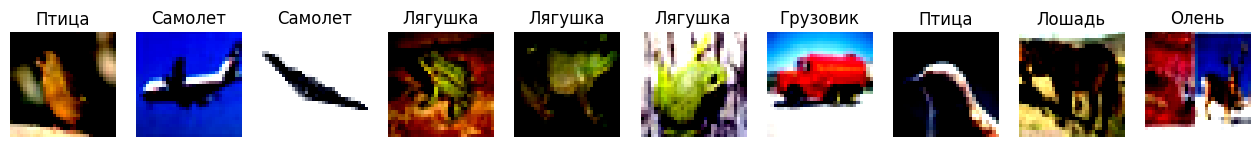

In [4]:
class_names = ['Самолет', 'Автомобиль', 'Птица', 'Кот', 'Олень',
               'Собака', 'Лягушка', 'Лошадь', 'Корабль', 'Грузовик']

images, labels = next(iter(train_loader))
fig, axes = plt.subplots(1, 10, figsize=(16, 16))
for ax, image, label in zip(axes, images, labels):
    image = image.permute(1, 2, 0)
    image = image * torch.tensor((0.4914, 0.4822, 0.4465)) + torch.tensor((0.2023, 0.1994, 0.2010))
    image = image.clamp(0, 1)
    ax.set_title(class_names[label])
    ax.imshow(image)
    ax.axis("off")
plt.show()

Построение свёрточной модели

In [5]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential( nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(), nn.MaxPool2d(2, 2) )
        self.layer2 = nn.Sequential( nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(), nn.MaxPool2d(2, 2) )
        self.layer3 = nn.Sequential( nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(), nn.MaxPool2d(2, 2) )

        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.reshape(-1, 128 * 4 * 4)

        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

model = ConvNet()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (drop_out): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=2048, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)

Архитектура:

In [6]:
from torchsummary import summary
summary(model, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
         MaxPool2d-3           [-1, 32, 16, 16]               0
            Conv2d-4           [-1, 64, 16, 16]          18,496
              ReLU-5           [-1, 64, 16, 16]               0
         MaxPool2d-6             [-1, 64, 8, 8]               0
            Conv2d-7            [-1, 128, 8, 8]          73,856
              ReLU-8            [-1, 128, 8, 8]               0
         MaxPool2d-9            [-1, 128, 4, 4]               0
          Dropout-10                 [-1, 2048]               0
           Linear-11                  [-1, 512]       1,049,088
           Linear-12                   [-1, 10]           5,130
Total params: 1,147,466
Trainable params: 1,147,466
Non-trainable params: 0
---------------------------

Обучение:

In [7]:
start_time = time.time()
model.train()
num_epochs = 10

total_step = len(train_loader)
loss_list = []
acc_list = []
for epoch in range(num_epochs):
    timer2 = time.time()
    for i, (images, labels) in enumerate(train_loader):
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        acc_list.append(correct / total)

    print('Эпоха {}/{}. Ошибка классификации: {:.4f}. Точность: {:.2f}%. Время: {:.2f} сек'
                  .format(epoch + 1, num_epochs, loss.item(), (correct / total) * 100, time.time() - timer2) )

print(f"Общее время обучения: {time.time() - start_time:.4f} сек")

Эпоха 1/10. Ошибка классификации: 0.8613. Точность: 68.75%. Время: 26.40 сек
Эпоха 2/10. Ошибка классификации: 0.7609. Точность: 75.00%. Время: 26.42 сек
Эпоха 3/10. Ошибка классификации: 1.4509. Точность: 56.25%. Время: 25.48 сек
Эпоха 4/10. Ошибка классификации: 0.5416. Точность: 87.50%. Время: 25.45 сек
Эпоха 5/10. Ошибка классификации: 0.9034. Точность: 62.50%. Время: 25.84 сек
Эпоха 6/10. Ошибка классификации: 0.5343. Точность: 75.00%. Время: 26.65 сек
Эпоха 7/10. Ошибка классификации: 0.4154. Точность: 81.25%. Время: 26.53 сек
Эпоха 8/10. Ошибка классификации: 0.4534. Точность: 81.25%. Время: 26.91 сек
Эпоха 9/10. Ошибка классификации: 0.6091. Точность: 87.50%. Время: 26.89 сек
Эпоха 10/10. Ошибка классификации: 0.8380. Точность: 81.25%. Время: 25.78 сек
Общее время обучения: 262.3510 сек


Результаты:

In [8]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print("Точность на тестовом наборе данных:", correct / total)

Точность на тестовом наборе данных: 0.7471
